<h1>Round 2 (Modified Spindle Analysis)</h1>

Changes since the last analysis:

- Bandpass filtering at 11-16 Hz was performed AFTER the epochs were created. Specifically, the filtering was performed during the moving window stage of the process.

In [22]:
# Importing initial libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Importing libraries for machine learning via sk-learn:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Importing libraries for machine learning via Keras:
from keras.models import Sequential
from keras.layers import Dense, Activation

<h2>Data Pre-Processing</h2>

In [23]:
df = pd.read_csv('second_round.csv')
df.head(10)

,a,b,c,d,e,f,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff,label
0,0.568689,4.559096,-1.842171,1.592255,93.848968,-8.516219,14.336918,2203.706140,2442.885499,239.179344,0.902091,0.097909,14.936527,1.041823,-2.294196,2.239200,0.978119,0.949794,0
1,2.034924,-1.230386,-12.482721,1.512096,88.650542,4.889599,14.336918,2821.895556,3340.112401,518.216835,0.844850,0.155150,14.109172,0.984115,-3.790356,3.777824,1.439746,0.919160,0
2,1.283464,-2.858088,-14.320902,1.545020,95.395853,11.376532,15.360983,733.318583,916.628121,183.309548,0.800018,0.199982,15.182722,0.988395,-2.014106,2.550220,0.856293,0.894461,0
3,1.354609,2.682283,-2.703546,0.055413,75.229163,-2.614740,12.288786,2708.151715,2977.612056,269.460345,0.909505,0.090495,11.973093,0.974310,-2.453539,2.529360,1.038191,0.953707,0
4,1.488449,-7.022999,-24.564451,-1.488069,72.724450,-13.121169,12.288786,1733.202259,1864.917493,131.715234,0.929372,0.070628,11.574456,0.941871,-1.995830,1.865204,0.725852,0.964051,0
5,1.004930,1.317512,-2.540674,0.222876,87.566983,-10.756175,12.288786,793.988300,1277.712110,483.723799,0.621414,0.378586,13.936718,1.134100,-3.040841,2.723676,1.391005,0.788631,0
6,1.575594,-0.017116,-19.599633,-2.293854,92.216145,-6.002431,14.336918,846.669029,949.630349,102.961331,0.891577,0.108423,14.676655,1.023697,-1.731512,1.680922,0.641752,0.944255,0
7,0.077028,2.955697,-0.473472,3.815419,76.407547,6.089128,12.288786,395.821017,481.965269,86.144246,0.821265,0.178735,12.160639,0.989572,-1.203559,1.290112,0.587007,0.906149,0
8,0.994217,2.264423,-7.644942,-0.798423,92.527322,-0.605082,14.336918,574.447216,819.086824,244.639610,0.701326,0.298674,14.726181,1.027151,-2.049204,2.199371,0.989221,0.837456,0
9,0.683055,1.611951,-1.536528,-0.163737,87.523858,-12.002503,13.312852,534.757267,573.134723,38.377457,0.933039,0.066961,13.929855,1.046346,-0.948936,0.814089,0.391803,0.965993,0


<h2>QPS Parameter Statistics</h2>

Separating the QPS parameters from the other features, we'll first get some preliminary statistics behind the QPS parameters that have been obtained from the modified dataset creation method.

In [24]:
# Get the column names for the QPS parameters:
qps_params = list(df.columns[0:6])
qps_params.append('label')

# Pull part of the dataframe with columns that satisfy 'qps_params':
df_qps = df[qps_params]
df_qps.head()

,a,b,c,d,e,f,label
0,0.568689,4.559096,-1.842171,1.592255,93.848968,-8.516219,0
1,2.034924,-1.230386,-12.482721,1.512096,88.650542,4.889599,0
2,1.283464,-2.858088,-14.320902,1.545020,95.395853,11.376532,0
3,1.354609,2.682283,-2.703546,0.055413,75.229163,-2.614740,0
4,1.488449,-7.022999,-24.564451,-1.488069,72.724450,-13.121169,0


To observe the resultant statistics for ONLY spindles, we need to pull all rows with a corresponding ```label``` of 1. We'll then get the preliminary statistics as well as boxplots that visually describe the distribution of the parameter values.

In [27]:
# Pulling out ONLY spindle rows from the QPS dataframe:
df_qps_spindles = df_qps[df_qps['label'] == 1].reset_index(drop=True)

# Getting rough statistics for each parameter.
df_qps_spindles.iloc[:,0:6].describe()

,a,b,c,d,e,f
count,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000
mean,1.086083,1.581369,-14.439643,0.114518,82.646808,-2.602892
std,1.876865,10.192368,18.487856,2.257453,8.500366,16.755284
min,-50.000000,-57.040112,-233.971311,-21.469825,6.874588,-89.353211
25%,0.561852,-0.127437,-18.273879,-1.359763,77.468647,-11.622034
50%,1.257487,1.430519,-8.076896,0.116864,82.769155,-2.435255
75%,2.031765,2.959611,-3.568163,1.604562,87.762327,5.630403
max,3.798527,229.532816,16.478551,22.258222,158.097406,103.680217


The modified process has slightly changed the mean values for each parameter compared to the results from the first round. We note the following comparisons between the means:

- Parameter ```a```: Mean = 0.925576 (Round 1) VS 1.086083 (Round 2)
- Parameter ```b```: Mean = 1.125606 (Round 1) VS 1.581369 (Round 2)
- Parameter ```c```: Mean = -11.148034 (Round 1) VS -14.439643 (Round 2)
- Parameter ```d```: Mean = 0.084384 (Round 1) VS 0.114518 (Round 2)
- Parameter ```e```: Mean = 81.506274 (Round 1) VS 82.646808 (Round 2)
- Parameter ```f```: Mean = -1.708043 (Round 1) VS -2.602892 (Round 2)

The code cell below produces 6 boxplots to show the distribution of the parameter values visually. 

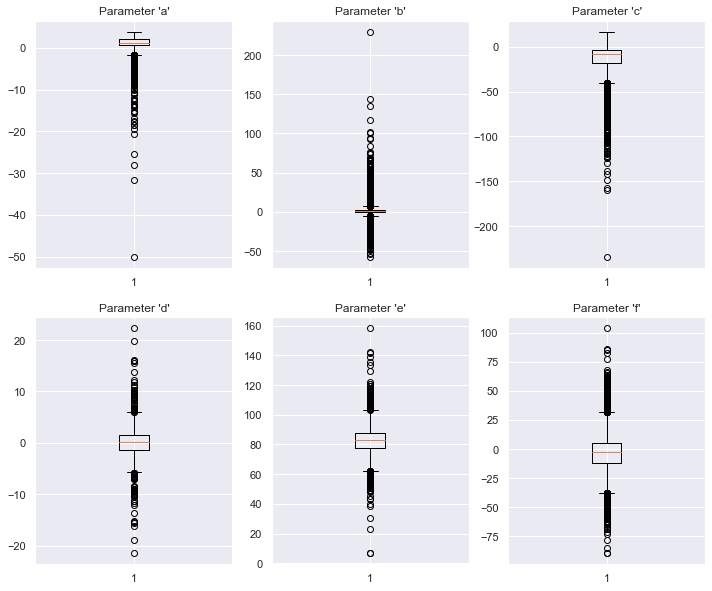

In [28]:
# Generate box plots for each column of the dataframe (other than the label):
fig, ax = plt.subplots(2,3,figsize=(12,10))
k = 0
for i in range(2):
    for j in range(3):
        ax[i,j].boxplot(df_qps_spindles.iloc[:,k])
        ax[i,j].set_title("Parameter '{}'".format(df_qps_spindles.columns[k]))
        
        k = k + 1

As with the previous analysis, the boxplots show many outliers. This is to be expected as the windowing process is not exactly perfect and may not capture the spindle in a way that allows the NLLS to perform optimally. However, we know for sure that this method minimises any form of bias in the process. 

Because we are filtering in the 11-16 Hz for non-spindles as well, we should also see how the QPS parameter statistics for non-spindles compare to the spindles. We hope to see somewhat of a statistical difference between the spindles and non-spindles at least for parameters other than the angular carrier frequency, $e$.

In [30]:
# Pulling out ONLY spindle rows from the QPS dataframe:
df_qps_nonspindles = df_qps[df_qps['label'] == 0].reset_index(drop=True)

# Getting rough statistics for each parameter.
df_qps_nonspindles.iloc[:,0:6].describe()

,a,b,c,d,e,f
count,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000
mean,0.801019,1.719908,-14.998958,0.165543,82.346485,-2.586949
std,1.723448,10.268317,19.645412,2.306827,9.203863,18.200597
min,-50.000000,-96.720825,-271.511568,-199.563938,-124.380105,-1119.458972
25%,0.365098,-0.026330,-19.386502,-1.313209,76.813327,-12.328398
50%,0.997229,1.461901,-7.913292,0.150309,82.277265,-2.588341
75%,1.640902,3.034954,-3.177559,1.629199,87.308459,6.884522
max,4.894867,240.956127,141.365479,61.993278,993.613529,222.712609


At face-value, it seems the only parameter that exhibits a large statistics difference between the spindles and non-spindles is the amplitude parameter, $a$. All other frequencies seem to perturb around similar values for spindles and non-spindles. 

The only way to fully compare the spindles and non-spindles is to perform a two-sided T-Test between the spindles and non-spindles. We perform the T-Test below. We use the same null and alternative hypotheses as with the first test, specifically at a significance level of $\alpha = 1$. That is, for a significant statistical difference between the spindles and non-spindles, we preferably want a $p$-value from the t-test such as $p << \alpha$.

- Null Hypothesis ($H_0$): The mean QPS parameter value for spindles and non-spindles exhibit little to no statistical difference.
- Alternate Hypothesis ($H_A$): The mean QPS parameter value for spindles and non-spindles exhibit a significant statistical difference.

In [46]:
# Import independent T-Test function from the Scipy library.
from scipy.stats import ttest_ind

# The T-test relies on the lengths of both spindle and non-spindle datasets being equal. 
# For this T-test, we'll need to chop the non-spindle chunk to a length equal to the spindle dataset. 
# Before chopping, the rows need to be randomised to ensure bias is minimised.
df_qps_nonspindles = df_qps_nonspindles.sample(frac=1).iloc[0:len(df_qps_spindles), :]

# Perform the T-test for each column and get the p-values for each column. Use a for-loop to automate the process.
t_val = {}
p_val = {}
for col in df_qps.columns[0:6]:
    t_val[col], p_val[col] = ttest_ind(df_qps_spindles[col], df_qps_nonspindles[col])

In [47]:
p_val

{'a': 2.9679033818773272e-21,
 'b': 0.5159921187438934,
 'c': 0.06294121923147007,
 'd': 0.08458874509177769,
 'e': 0.15814111055168376,
 'f': 0.7077018795543217}

We can see that the largest statistical difference between the spindles and non-spindles comes from the ```a``` parameter with a $p$-value that falls far below our significance level. The other parameters fall above the $\alpha$ value we specified with the $f$ parameter being the worst performing parameter for statistical difference between spindles and non-spindles.
<p></p>

<center>
<b style='color:green'>$\therefore$ Parameter 'a' should be selected as a feature for a machine learning algorithm later.</b>
</center>

<h2>Other Parameter Statistics</h2>

In the same fashion, we should analyse the statistics behind the other features computed other than the QPS parameters. To review, the definitions of the other parameters are defined below.

- ```real_freq_hz```: The peak frequency of the raw spindle. This was used as a temporary parameter for computing other features.
- ```qps_energy```: The energy of the fitted QPS spindle. The energy is computed in the time-domain. The energy was computed according to the following formula:

\begin{equation}
    E_{qps} = \sum_{n = 1}^{N} |x_{qps}[n]|^2
\end{equation}

- ```real_energy```: The energy of the raw spindle captured by the moving window. Energy computed with the same equation above.

\begin{equation}
    E_{real} = \sum_{n = 1}^{N} |x_{real}[n]|^2
\end{equation}

- ```residual_energy```: The energy computed from the difference (error) between the raw spindle and the fitted QPS. The difference is computed first and THEN the energy was computed. Hence:

\begin{equation}
    E_{residual} = \sum_{n = 1}^{N} |x_{qps}[n] - x_{real}[n]|^2
\end{equation}

- ```qser```: QPS-to-Spindle Energy Ratio. Ideally, we want QSER to be as close to 1 (i.e. 100%). That is:

\begin{equation}
    QSER = \frac{E_{QPS}}{E_{real}}
\end{equation}

- ```rser```: Residual-to-Spindle Energy Ratio. Ideally, we want RSER as small as possible. That is:

\begin{equation}
    QSER = \frac{E_{residual}}{E_{real}}
\end{equation}

- ```qps_freq_hz```: The peak frequency of the fitted/generated QPS spindle. 
- ```qrfr```: QPS-to-Residual Frequency Ratio.
- ```min_residual```: The minimum value of the residual generated for a particular spindle and its QPS
- ```max_residual```: The maximum value of the residual
- ```rms_residual```: The RMS value for the residual.
- ```raw_qps_corrcoeff```: The correlation coefficient between the raw spindle and the QPS. The better the fit of the QPS to the captured raw spindle, the greater the value of the correlation coefficient.

The same process of obtaining the statistics for the other parameters is performed in the subsequent code cells below:

In [51]:
# Get the column names for the QPS parameters:
other_params = list(df.columns[6:18])
other_params.append('label')

# Pull part of the dataframe with columns that satisfy 'qps_params':
df_other = df[other_params]
df_other.head()

,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff,label
0,14.336918,2203.706140,2442.885499,239.179344,0.902091,0.097909,14.936527,1.041823,-2.294196,2.239200,0.978119,0.949794,0
1,14.336918,2821.895556,3340.112401,518.216835,0.844850,0.155150,14.109172,0.984115,-3.790356,3.777824,1.439746,0.919160,0
2,15.360983,733.318583,916.628121,183.309548,0.800018,0.199982,15.182722,0.988395,-2.014106,2.550220,0.856293,0.894461,0
3,12.288786,2708.151715,2977.612056,269.460345,0.909505,0.090495,11.973093,0.974310,-2.453539,2.529360,1.038191,0.953707,0
4,12.288786,1733.202259,1864.917493,131.715234,0.929372,0.070628,11.574456,0.941871,-1.995830,1.865204,0.725852,0.964051,0


In [52]:
# Pulling out ONLY spindle rows from the QPS dataframe:
df_other_spindles = df_other[df_other['label'] == 1].reset_index(drop=True)

# Getting rough statistics for each parameter.
df_other_spindles.iloc[:,0:12].describe()

,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff
count,6539.000000,6.539000e+03,6539.000000,6539.000000,6.539000e+03,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000
mean,13.100334,5.335514e+03,6069.498999,733.991129,7.821954e-01,0.217805,13.153648,1.007665,-3.608521,3.604752,1.399523,0.877802
std,1.136707,9.335534e+03,9988.253415,1589.742622,1.692877e-01,0.169289,1.352875,0.102426,2.674455,2.655791,0.988660,0.108713
min,10.240655,2.700000e-16,47.653249,5.852367,1.030000e-20,0.002474,1.094125,0.071228,-35.742447,0.410145,0.153002,-0.240768
25%,12.288786,4.935395e+02,716.009973,147.667728,6.945313e-01,0.086341,12.329518,0.970616,-4.393603,1.951689,0.768551,0.833358
50%,13.312852,1.444455e+03,1885.093611,307.069236,8.215217e-01,0.178478,13.173120,1.001384,-2.857973,2.831524,1.108277,0.906463
75%,14.336918,5.460581e+03,6531.052052,757.006463,9.136594e-01,0.305469,13.967808,1.035034,-1.956562,4.383706,1.740122,0.955864
max,16.385049,1.077365e+05,112766.683400,59317.095000,9.975256e-01,1.000000,25.161984,1.960408,-0.390251,35.981347,15.403518,0.998762


In [54]:
len(df_other_spindles.columns)

13

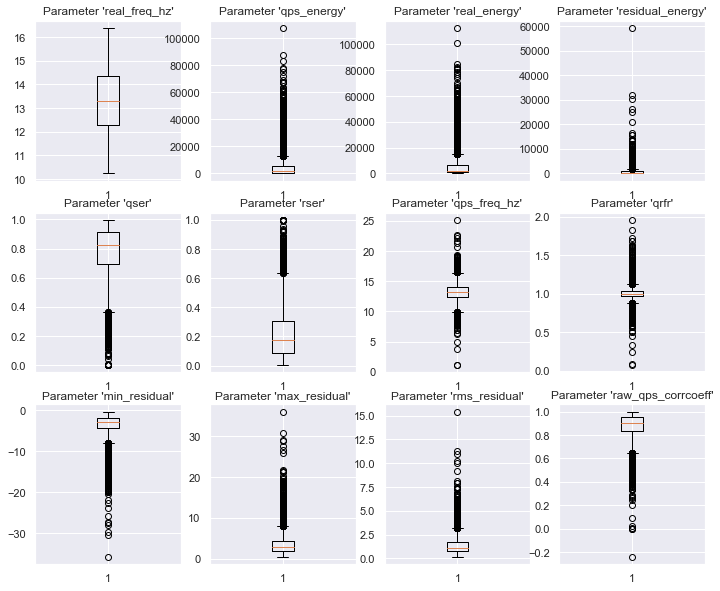

In [55]:
# Generate box plots for each column of the dataframe (other than the label):
fig, ax = plt.subplots(3,4,figsize=(12,10))
k = 0
for i in range(3):
    for j in range(4):
        ax[i,j].boxplot(df_other_spindles.iloc[:,k])
        ax[i,j].set_title("Parameter '{}'".format(df_other_spindles.columns[k]))
        
        k = k + 1

In [56]:
# Pulling out ONLY spindle rows from the QPS dataframe:
df_other_nonspindles = df_other[df_other['label'] == 0].reset_index(drop=True)

# Getting rough statistics for each parameter.
df_other_nonspindles.iloc[:,0:12].describe()

,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff
count,503942.000000,5.039420e+05,503942.000000,503942.000000,5.039420e+05,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000
mean,13.019426,2.875663e+03,3417.350758,541.688233,7.563434e-01,0.243657,13.105850,1.010834,-3.122841,3.121357,1.207108,0.862408
std,1.170315,6.069657e+03,6686.958371,1310.047670,1.724139e-01,0.172414,1.464840,0.115118,2.262524,2.260373,0.842405,0.112658
min,9.216590,6.180000e-23,25.926293,2.558946,1.190000e-27,0.001050,-19.795709,-1.591842,-68.572338,0.204183,0.101172,-0.720739
25%,12.288786,3.712707e+02,552.037855,118.043347,6.650208e-01,0.110951,12.225221,0.968352,-3.751196,1.737122,0.687149,0.815521
50%,13.312852,8.948520e+02,1227.312265,239.342600,7.922266e-01,0.207773,13.094833,1.002541,-2.506256,2.504357,0.978453,0.890104
75%,14.336918,2.714071e+03,3387.899479,526.427434,8.890494e-01,0.334979,13.895573,1.039536,-1.737895,3.748855,1.451106,0.942916
max,17.409114,5.856274e+05,683205.829500,108834.903200,9.989496e-01,1.000000,158.138505,11.878635,-0.242341,72.876314,20.864794,0.999475


In [59]:
# Import independent T-Test function from the Scipy library.
from scipy.stats import ttest_ind

# The T-test relies on the lengths of both spindle and non-spindle datasets being equal. 
# For this T-test, we'll need to chop the non-spindle chunk to a length equal to the spindle dataset. 
# Before chopping, the rows need to be randomised to ensure bias is minimised.
df_other_nonspindles = df_other_nonspindles.sample(frac=1).iloc[0:len(df_other_spindles), :]

# Perform the T-test for each column and get the p-values for each column. Use a for-loop to automate the process.
t_val_other = {}
p_val_other = {}
for col in df_other.columns[0:12]:
    t_val_other[col], p_val_other[col] = ttest_ind(df_other_spindles[col], df_other_nonspindles[col])


In [60]:
p_val_other

{'real_freq_hz': 0.002378506898893982,
 'qps_energy': 2.3676468036282623e-61,
 'real_energy': 1.170915226893126e-61,
 'residual_energy': 2.0602801651107817e-14,
 'qser': 3.25727670645664e-24,
 'rser': 3.2621148319634145e-24,
 'qps_freq_hz': 0.130325470982688,
 'qrfr': 0.1726965084504199,
 'min_residual': 6.80671210174473e-26,
 'max_residual': 4.392089767270668e-25,
 'rms_residual': 1.5907094806869717e-28,
 'raw_qps_corrcoeff': 3.020440697957548e-21}

From the above p-values, we'll pick the following as selected features for a machine learning process in the latter part of the notebook. Note that any features associated with the raw spindle alone will be omitted. This is because these features are independent of the QPS model which we want to test its ability to distinguish between spindles and non-spindles.

- ```qps_energy```
- ```residual_energy```
- ```qser```
- ```rser```
- ```min_residual```
- ```max_residual```
- ```rms_residual```
- ```raw_qps_corrcoeff```

<h1>Classification With and Without Feature Selection</h1>

In this section, we will perform classification with an SVM and a neural network (later in the project) in two scenario:

1. Classification using ALL columns as features
2. Classification using ONLY features selected from the T-Test.

What we hope to see as an improvement in the accuracy (and other metrics) when performing scenario 2. The classification process begins in the code cell below. 

<h2>Scenario 1: Classification Using ALL Features</h2>

<h3>Using A <i>Support Vector Machine (SVM)</i></h3>

In [90]:
# Begin by taking the original dataframe, 'df' and splitting it into spindles and non-spindles.
# Ensure, non-spindles have the same length as the spindle subset and shuffle rows to ensure randomisation.
spindles = df[df['label'] == 1].reset_index(drop=True)
non_spindles = df[df['label'] == 0].sample(frac=1).iloc[0:len(spindles), :].reset_index(drop=True)

# Join both spindle and non-spindle data subsets together. Shuffle the rows after concatenation
all_features = pd.concat([spindles, non_spindles], axis=0)
all_features = all_features.sample(frac=1).reset_index(drop=True)
X = all_features.iloc[:, 0:18]
y = all_features.iloc[:,18]

# Split the 'all_features' dataframe into training and test subsets. CV is performed using 'cross_val_score'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalise training set first and map mean and variance of standardised training set onto the test set.
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

# Instantiate an empty SVM model
model = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')

# Evaluate the accuracy score by cross-validation:
acc_scores_cv = cross_val_score(model, X_train, y_train, cv=5)

print("List Of Accuracies For Each Fold = {}".format(acc_scores_cv))
print("Average Accuracy = {}%".format(round(np.mean(acc_scores_cv), 3)))

List Of Accuracies For Each Fold = [0.55682904 0.56453155 0.5626195  0.56166348 0.53632887]
Average Accuracy = 0.556%


In [91]:
len(all_features.columns)

19

<h3>Using A Neural Network</h3>

Perhaps an ANN might yield better (or just <i>different</i> results) from using a quic algorithm like an SVM. The procedure to preparing an ANN is performed below.

Train on 8369 samples, validate on 2093 samples
Epoch 1/500
8369/8369 [==============================] - 1s 69us/step - loss: 0.6821 - acc: 0.5602 - val_loss: 0.6896 - val_acc: 0.5356
Epoch 2/500
8369/8369 [==============================] - 0s 30us/step - loss: 0.6759 - acc: 0.5712 - val_loss: 0.6907 - val_acc: 0.5351
Epoch 00002: early stopping
Train: 0.569, Test: 0.547


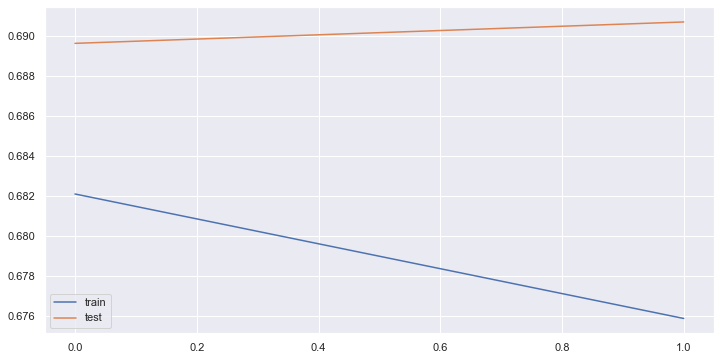

In [98]:
model_nn = Sequential()
model_nn.add(Dense(38, activation='relu', input_dim=18))
model_nn.add(Dense(38, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model_nn.fit(X_train, y_train, validation_split=0.2, epochs=500, callbacks=[es])

# evaluate the model
_, train_acc = model_nn.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_nn.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<h2>Scenario 2: Classification Using Only SELECTED Features</h2>

In [89]:
# Begin by first selecting the columns we want from the T-Test performed in the earlier part of the notebook.
selected = ['a', 'qps_energy', 'residual_energy', 'qser', 'rser',
            'min_residual','max_residual','rms_residual','raw_qps_corrcoeff', 'label']
df_sel = df[selected]

# Begin by taking the original dataframe, 'df' and splitting it into spindles and non-spindles.
# Ensure, non-spindles have the same length as the spindle subset and shuffle rows to ensure randomisation.
spindles_sel = df_sel[df_sel['label'] == 1].reset_index(drop=True)
non_spindles_sel = df_sel[df_sel['label'] == 0].sample(frac=1).iloc[0:len(spindles), :].reset_index(drop=True)

# Join both spindle and non-spindle data subsets together. Shuffle the rows after concatenation
all_features_sel = pd.concat([spindles_sel, non_spindles_sel], axis=0)
all_features_sel = all_features_sel.sample(frac=1).reset_index(drop=True)
X = all_features_sel.iloc[:, 0:9]
y = all_features_sel.iloc[:,9]

# Split the 'all_features' dataframe into training and test subsets. CV is performed using 'cross_val_score'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Normalise training set first and map mean and variance of standardised training set onto the test set.
from sklearn.preprocessing import MinMaxScaler 
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

# Instantiate an empty SVM model
model = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')

# Evaluate the accuracy score by cross-validation:
acc_scores_cv = cross_val_score(model, X_train, y_train, cv=5)

print("List Of Accuracies For Each Fold = {}".format(acc_scores_cv))
print("Average Accuracy = {}%".format(round(np.mean(acc_scores_cv), 3)))

List Of Accuracies For Each Fold = [0.5649516  0.54536188 0.55889852 0.55430903 0.56297807]
Average Accuracy = 0.557%


<h2>Scatter Plot Of Features</h2>

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


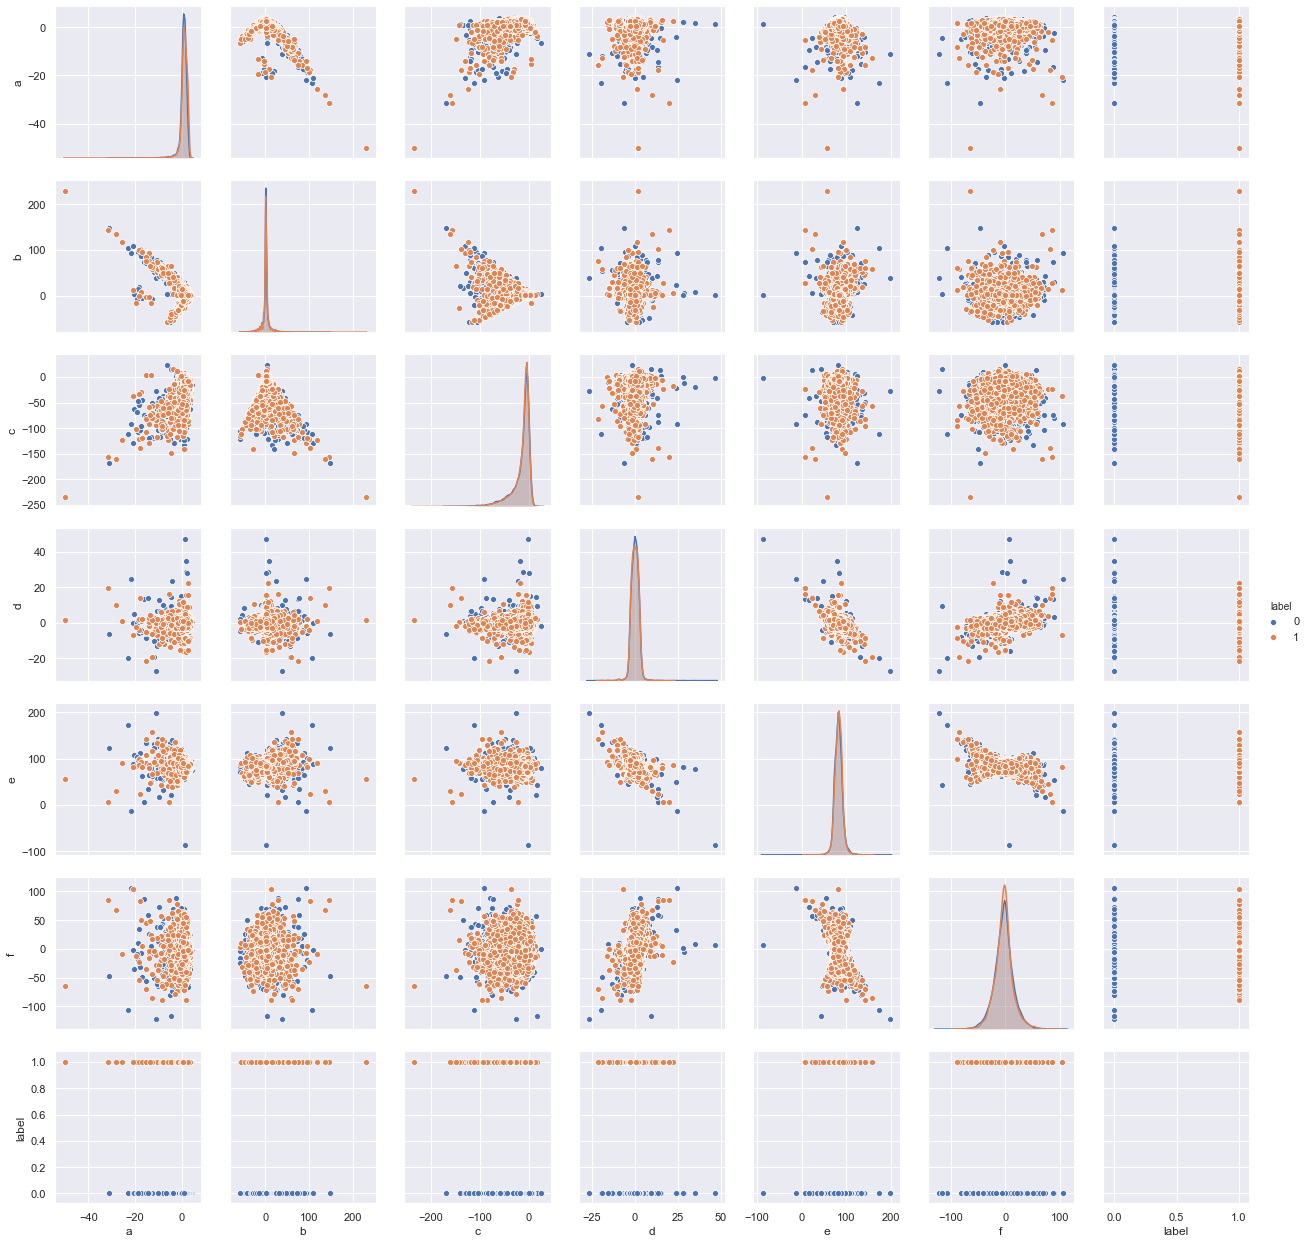

In [99]:
features = ['a', 'b', 'c', 'd', 'e', 'f', 'label']
to_plot = all_features[features].copy()
g = sns.pairplot(to_plot, hue='label')

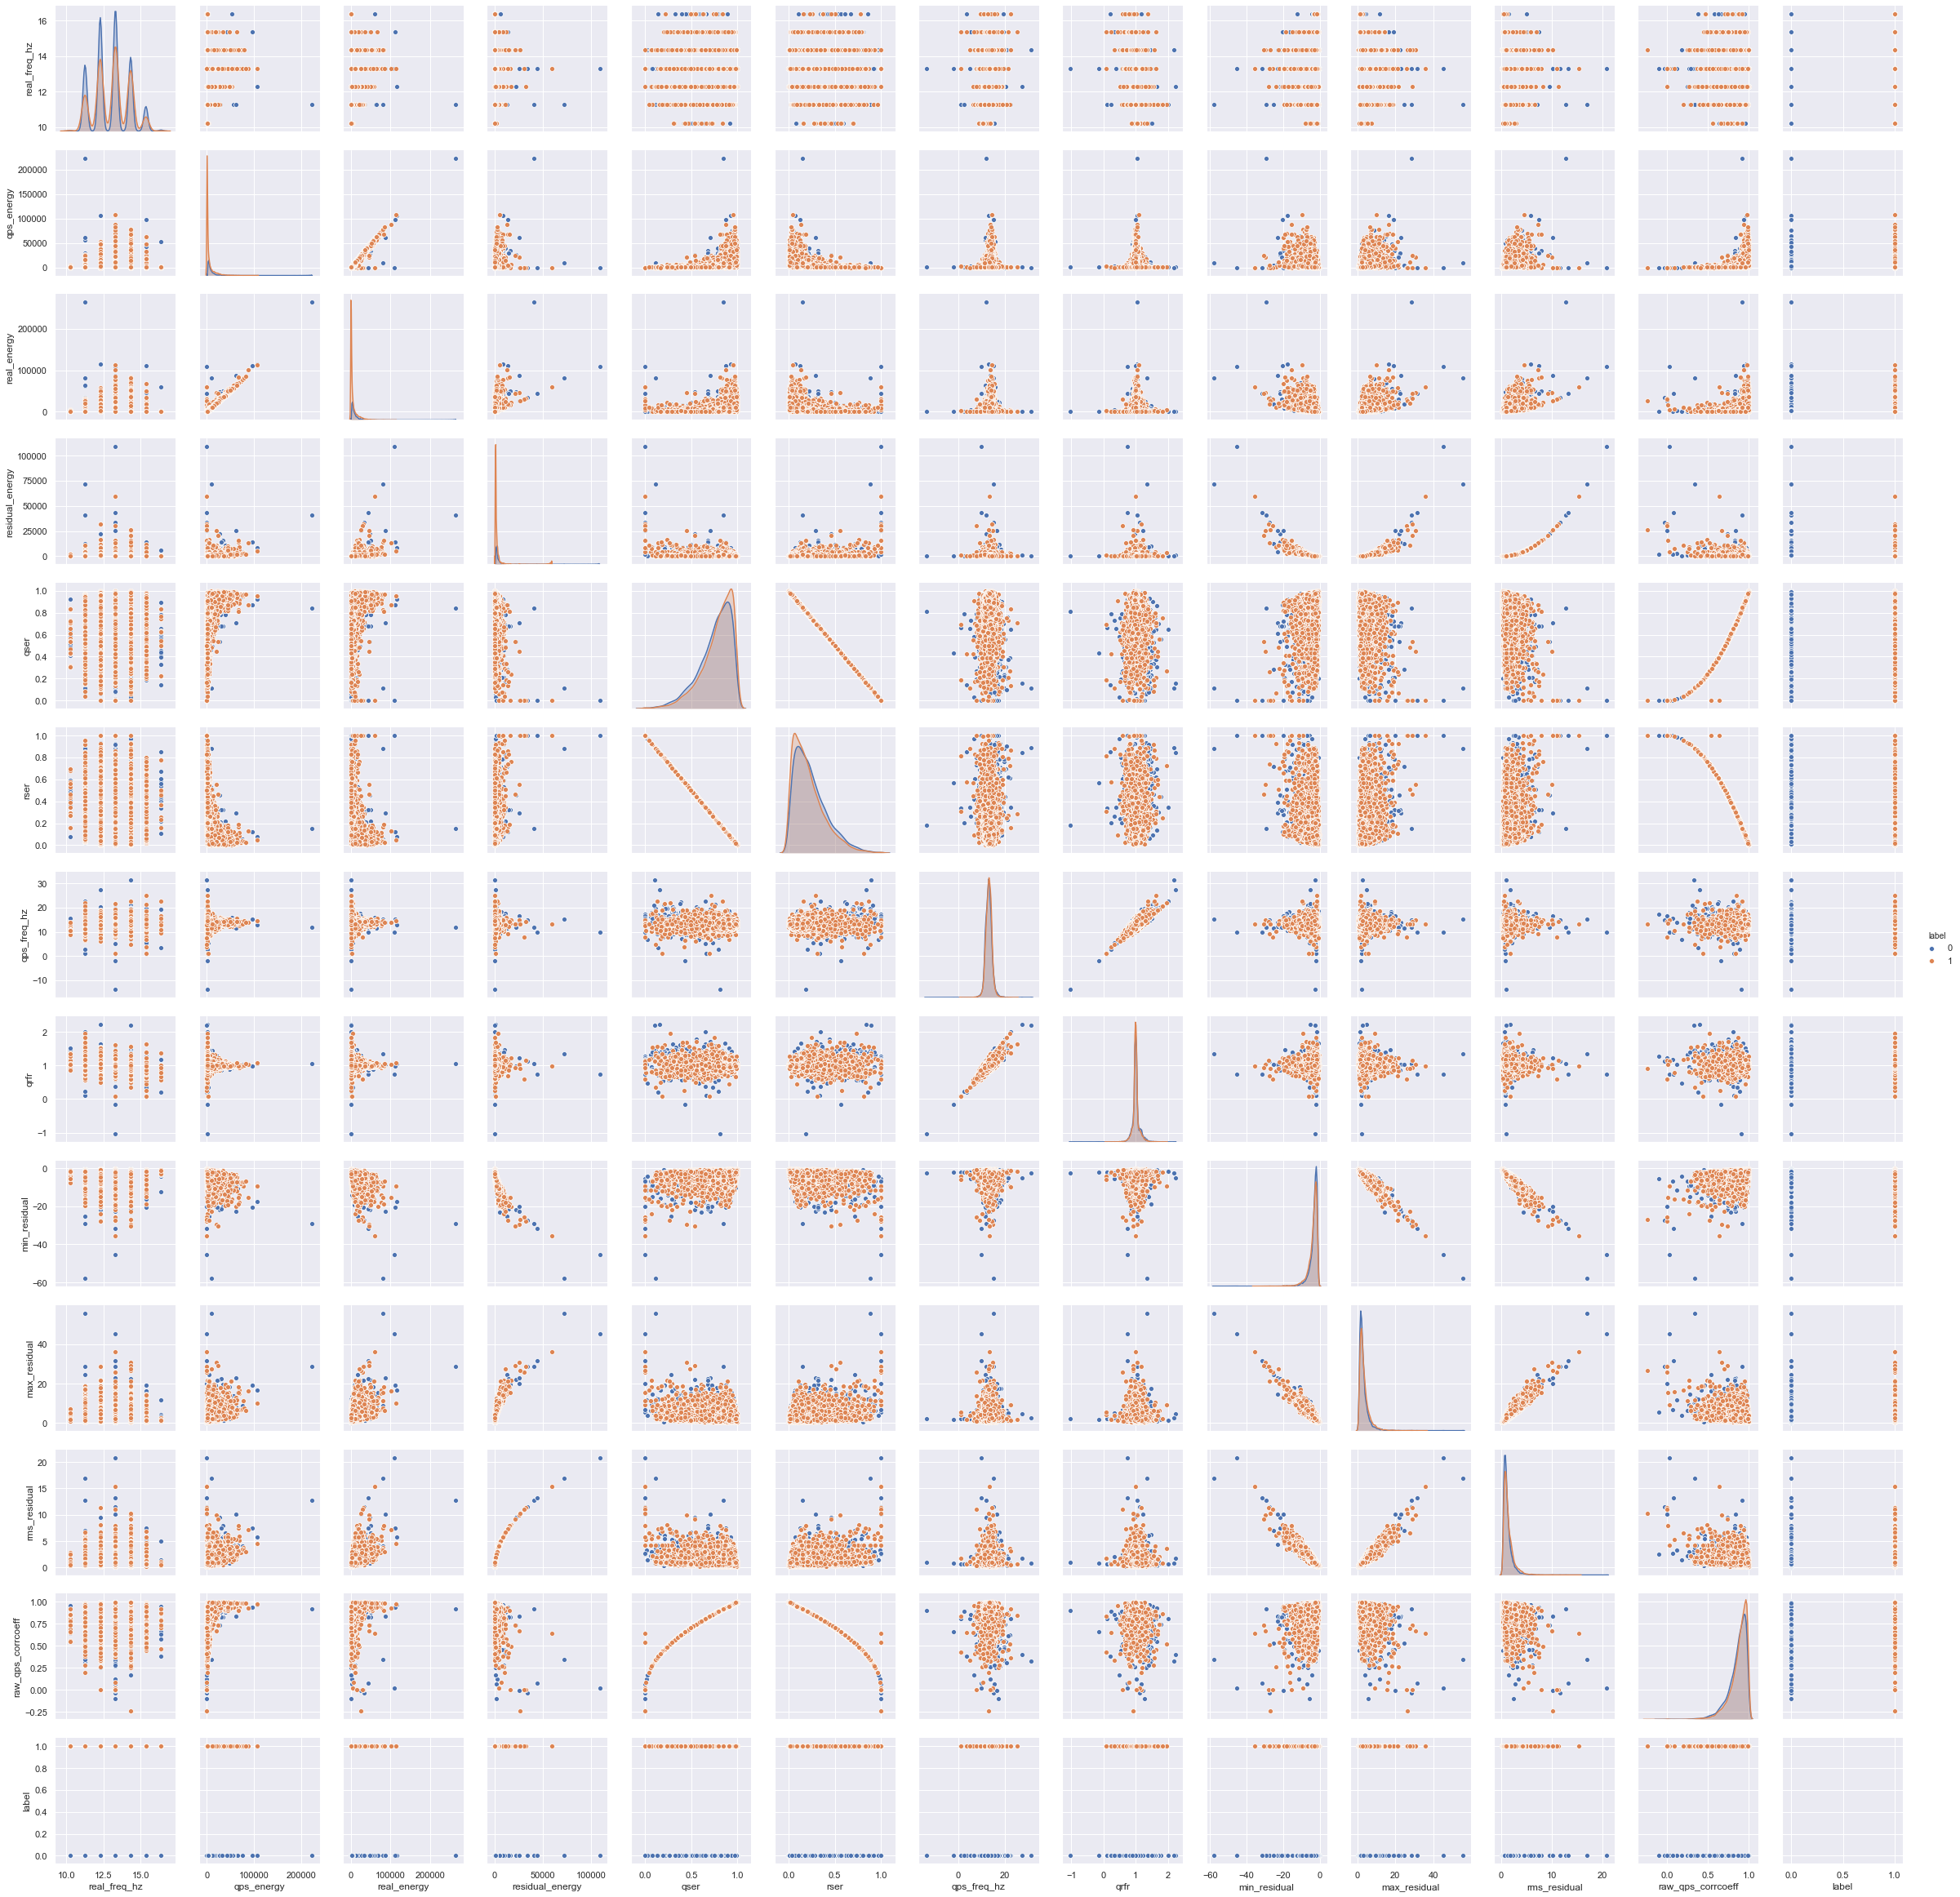

In [100]:
features = df_other.columns[0:13]
to_plot = all_features[features].copy()
g = sns.pairplot(to_plot, hue='label')